# Electricity Demand Forecasting

The main goal of this notebook is to forecast daily electricity demand in Alberta (Canada). Here, we primarily focus on classical time series methods applied to multi-step forecasting (30-day ahead). We extensively use the DARTS library which is specifically created for time series forecasting tasks and has a variety of popular classical time series models as well as ML models implemented as wrappers. The data spans a time interval from 2000-01-01 to 2019-12-31.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from darts import TimeSeries, concatenate
from darts.models import NaiveSeasonal, NaiveDrift, TBATS, Prophet, Theta
from darts.metrics import rmse
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality
plt.rcParams.update({'figure.figsize':(18,10), 'figure.dpi':120})

In [2]:
df = pd.read_csv(r'electricityDailyLoad.csv')
df['dt'] = pd.to_datetime(df['dt'])
df.sort_values(by='dt', inplace=True)
df.drop_duplicates(subset=["dt"], keep='first', inplace=True)


We keep the interval from 2019-01-01 to 2019-12-31 for validation, and the rest - for training.

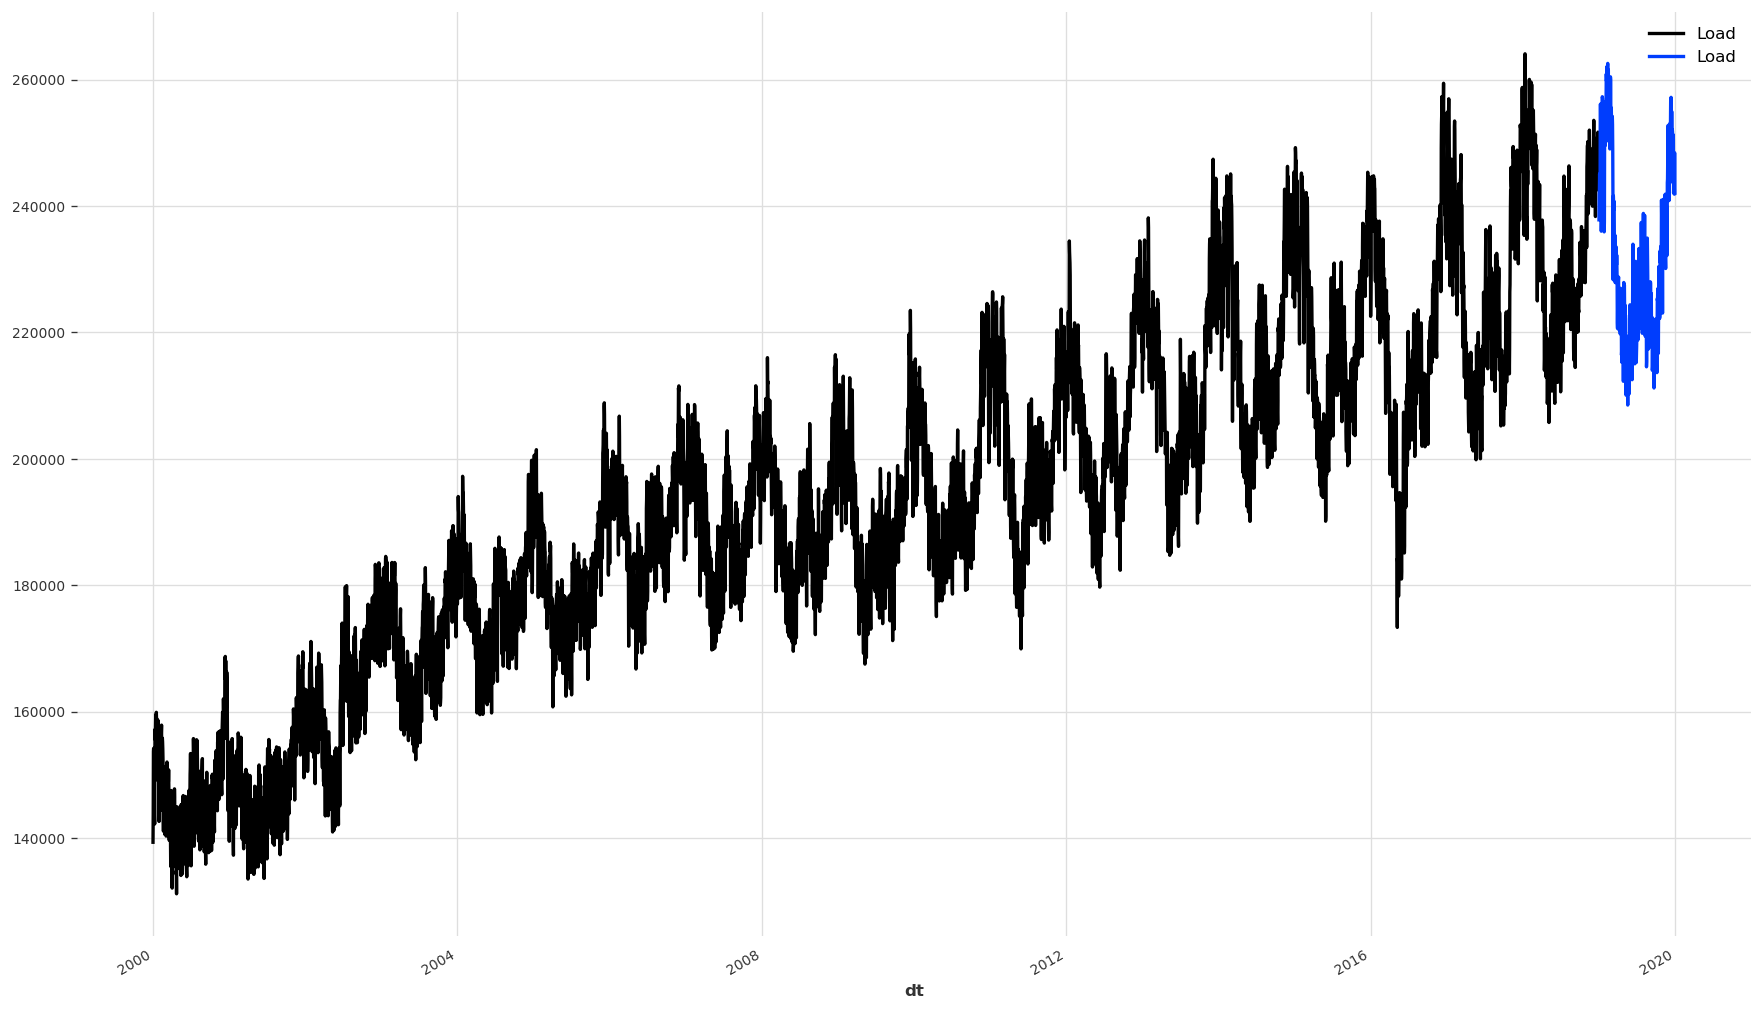

In [31]:
series = TimeSeries.from_dataframe(df,"dt","Load")
train, val = series.split_before(pd.Timestamp("20190101"))

train.plot()
val.plot()

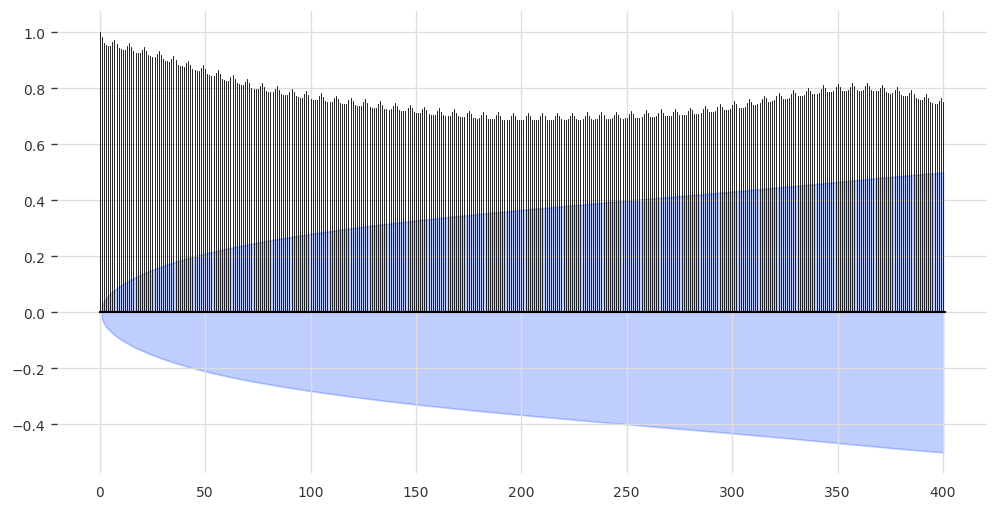

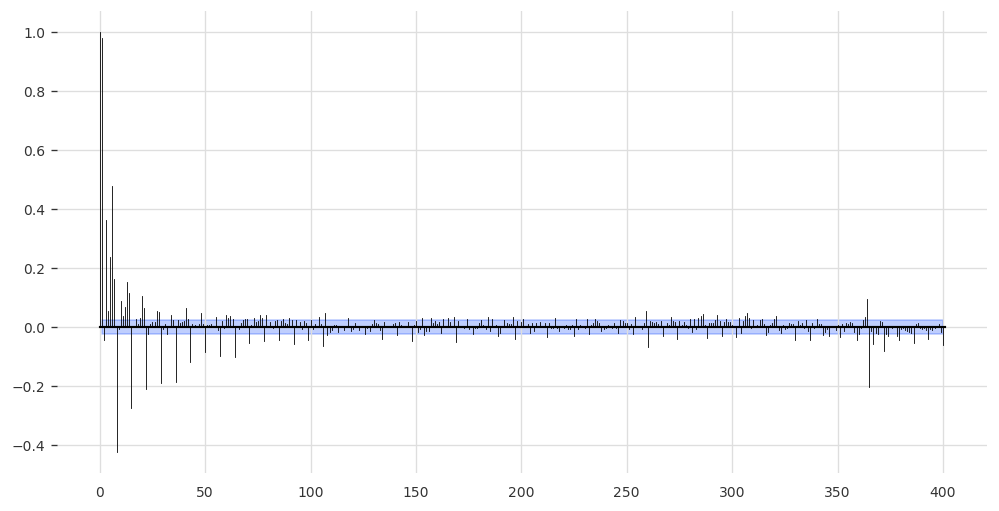

In [4]:
plot_acf(series, max_lag=400)
plot_pacf(series, max_lag=400)

Instead of doing STL decomposition, we will run a Prophet model and use its built-in functionality to see the trend and the seasonlity components. This time series is interesting to investigate because it has multiple seasonalities (weekly and yearly).

17:24:49 - cmdstanpy - INFO - Chain [1] start processing
17:24:49 - cmdstanpy - INFO - Chain [1] done processing


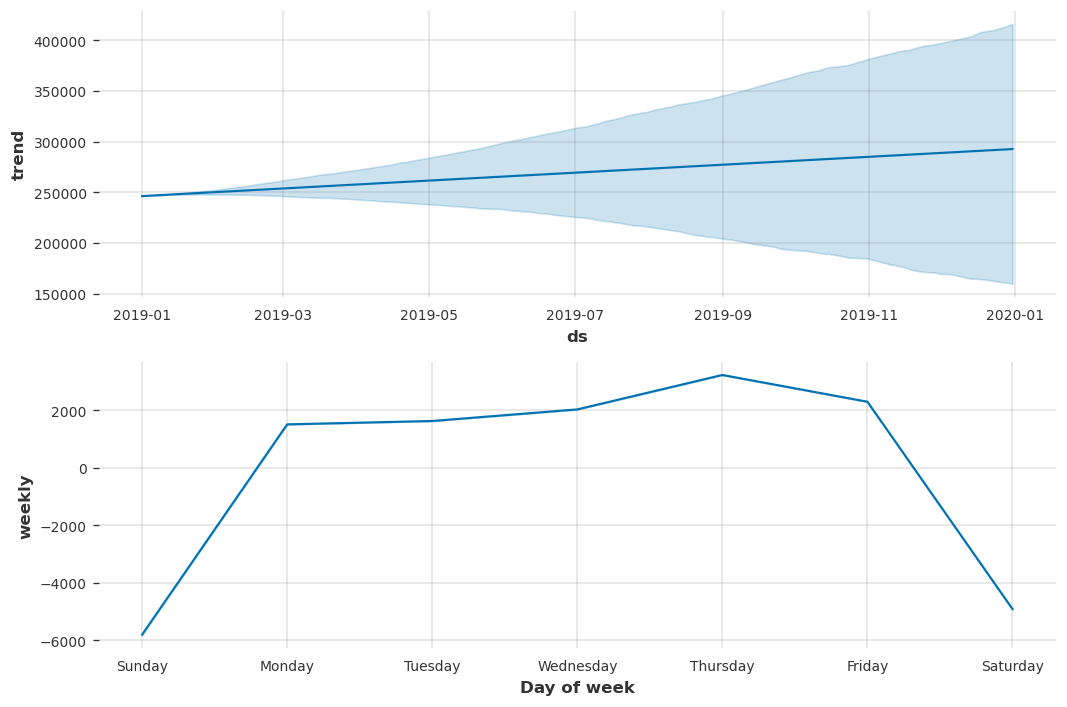

In [19]:
prophet = Prophet()
prophet.fit(train)
forecast = prophet.predict(len(val))
fig2 = prophet.model.plot_components(prophet.predict_raw(len(val)))

model Prophet obtains MSE: 20576.19


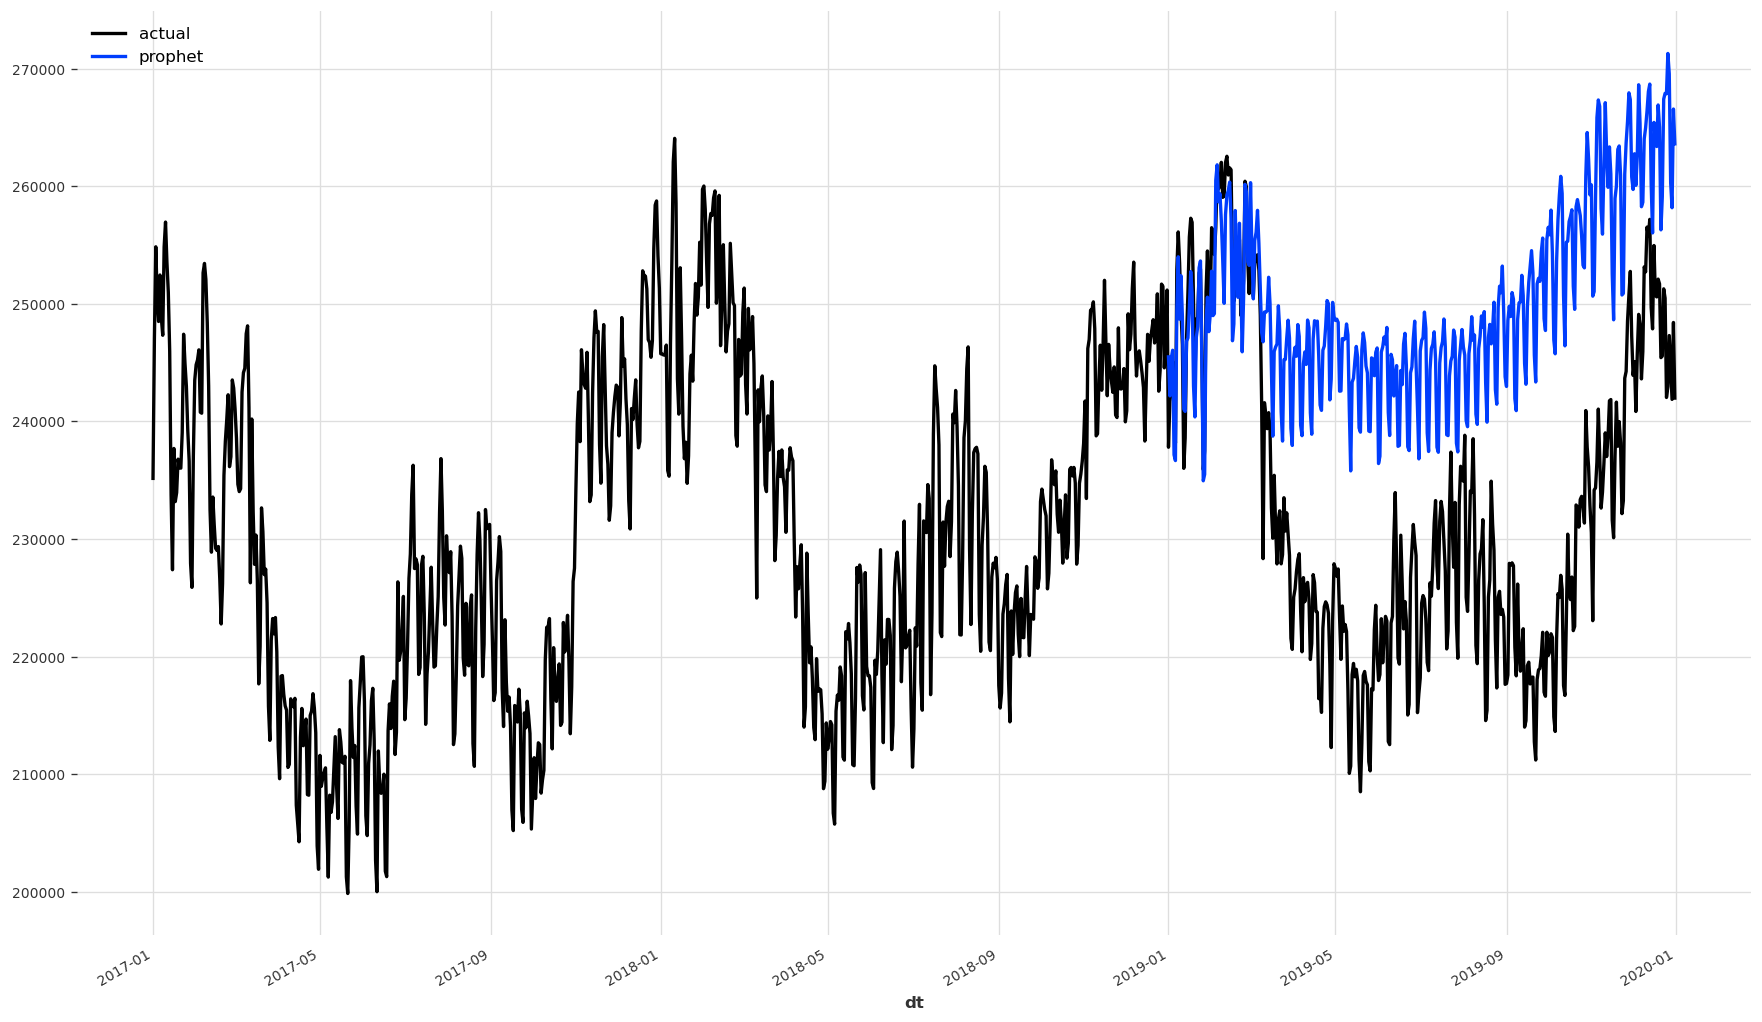

In [17]:
print("model {} obtains MSE: {:.2f}".format(prophet, rmse(val, forecast)))
series[-365*3:].plot(label="actual")
forecast.plot(label="prophet")

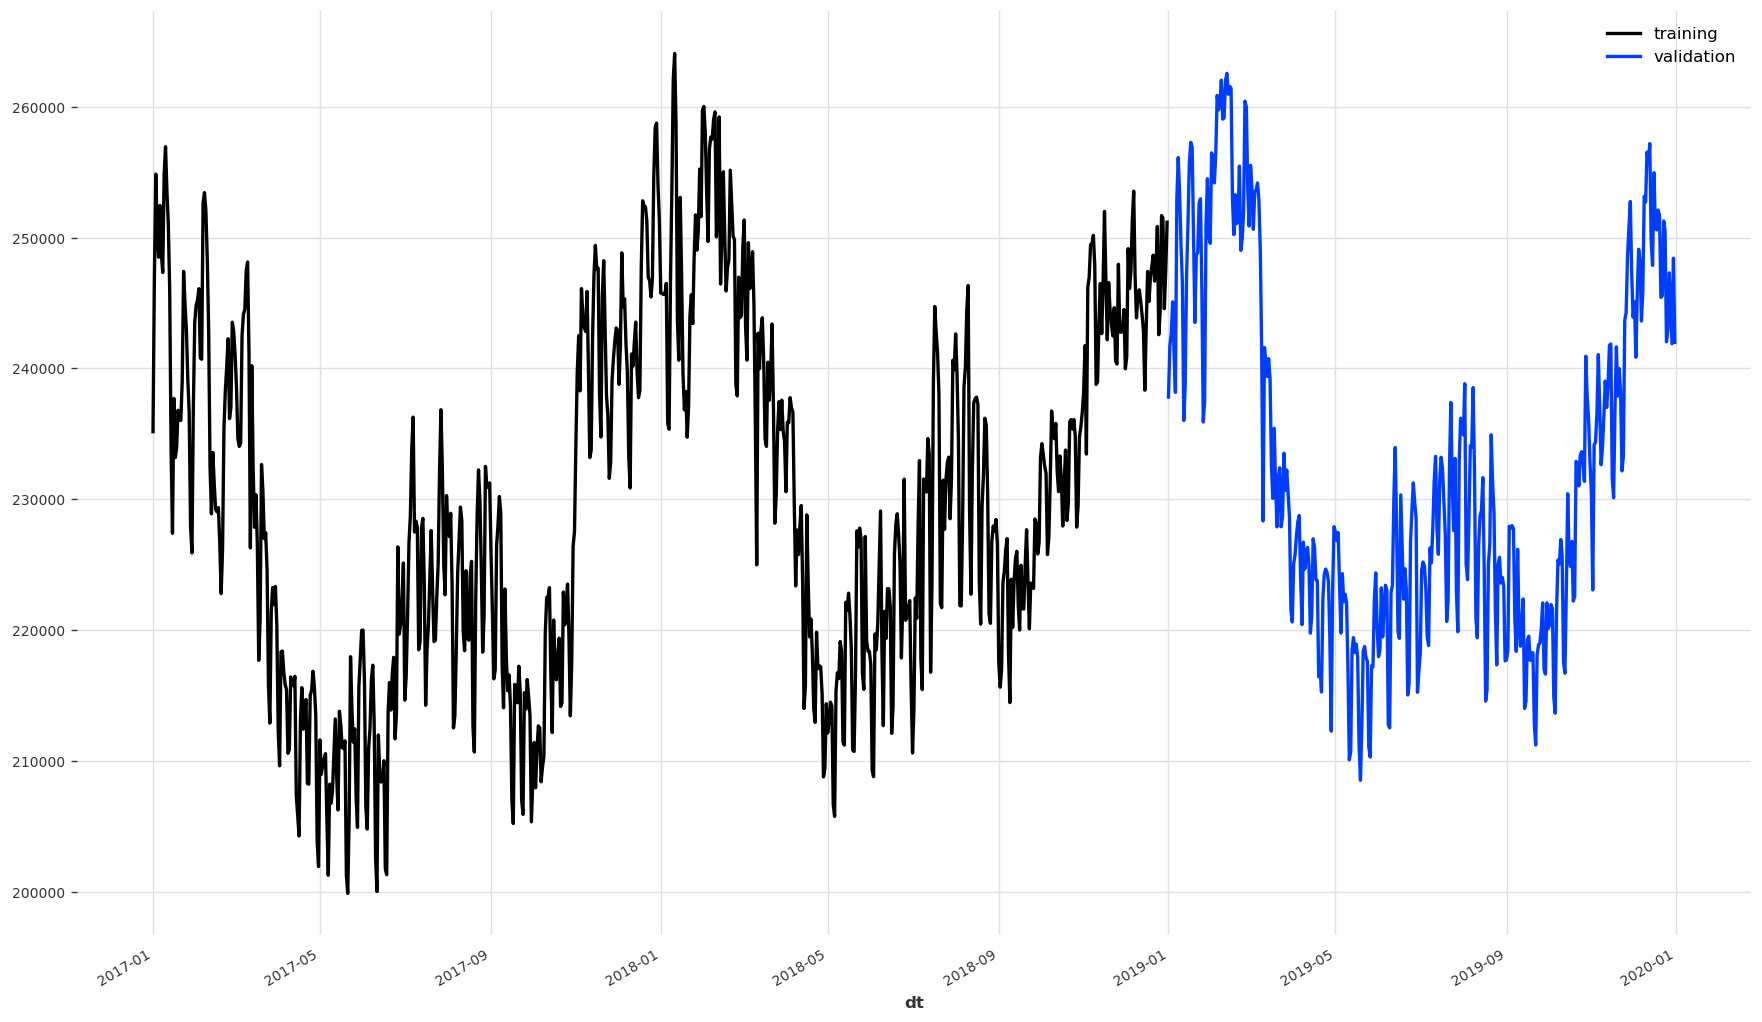

In [7]:
train = train[-365*2:]
train.plot(label="training")
val.plot(label="validation")

To judge how well our models perform, we will make 12 consequent non-overlaping 30-day ahead forecasts starting from 2019-01-01.

In [24]:
# function to calc RMSE; and also plot results
def eval_results(model):
    forecast = model.predict(360)
    forecast.plot(label="forecast")
    val.plot()
    print("Total error (RMSE) over all historical forecasts: %.2f" % rmse(val,forecast))

    error=[]
    for i in range(0,12):
        error.append(rmse(forecast[i*30:i*30+30], val[i*30:i*30+30]))

    average_error = np.mean(error)
    print("Average error (RMSE) over all historical forecasts: %.2f" % average_error)

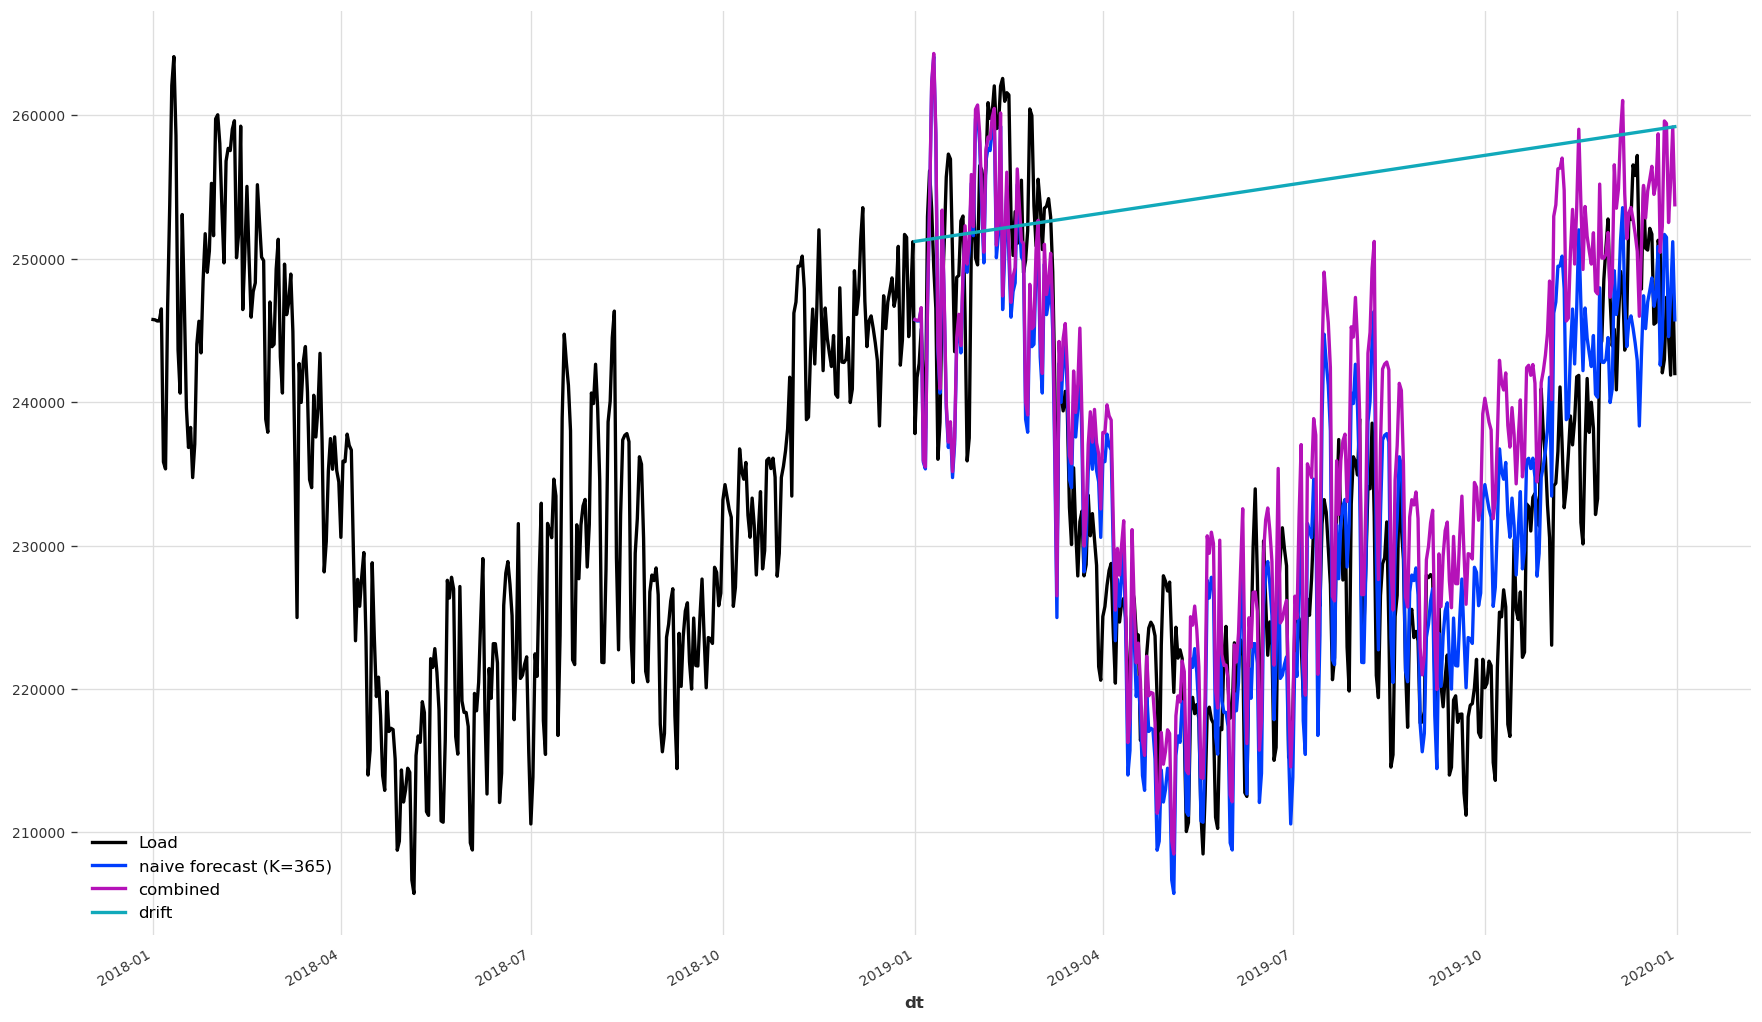

In [9]:
seasonal_model = NaiveSeasonal(K=364)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

drift_model = NaiveDrift()
drift_model.fit(train[-365*2:])
drift_forecast = drift_model.predict(365)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series[-365*2:].plot()
seasonal_forecast.plot(label="naive seasonal forecast (K=364)")
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

Total error (RMSE) over all historical forecasts: 7273.22
Average error (RMSE) over all historical forecasts: 7157.74


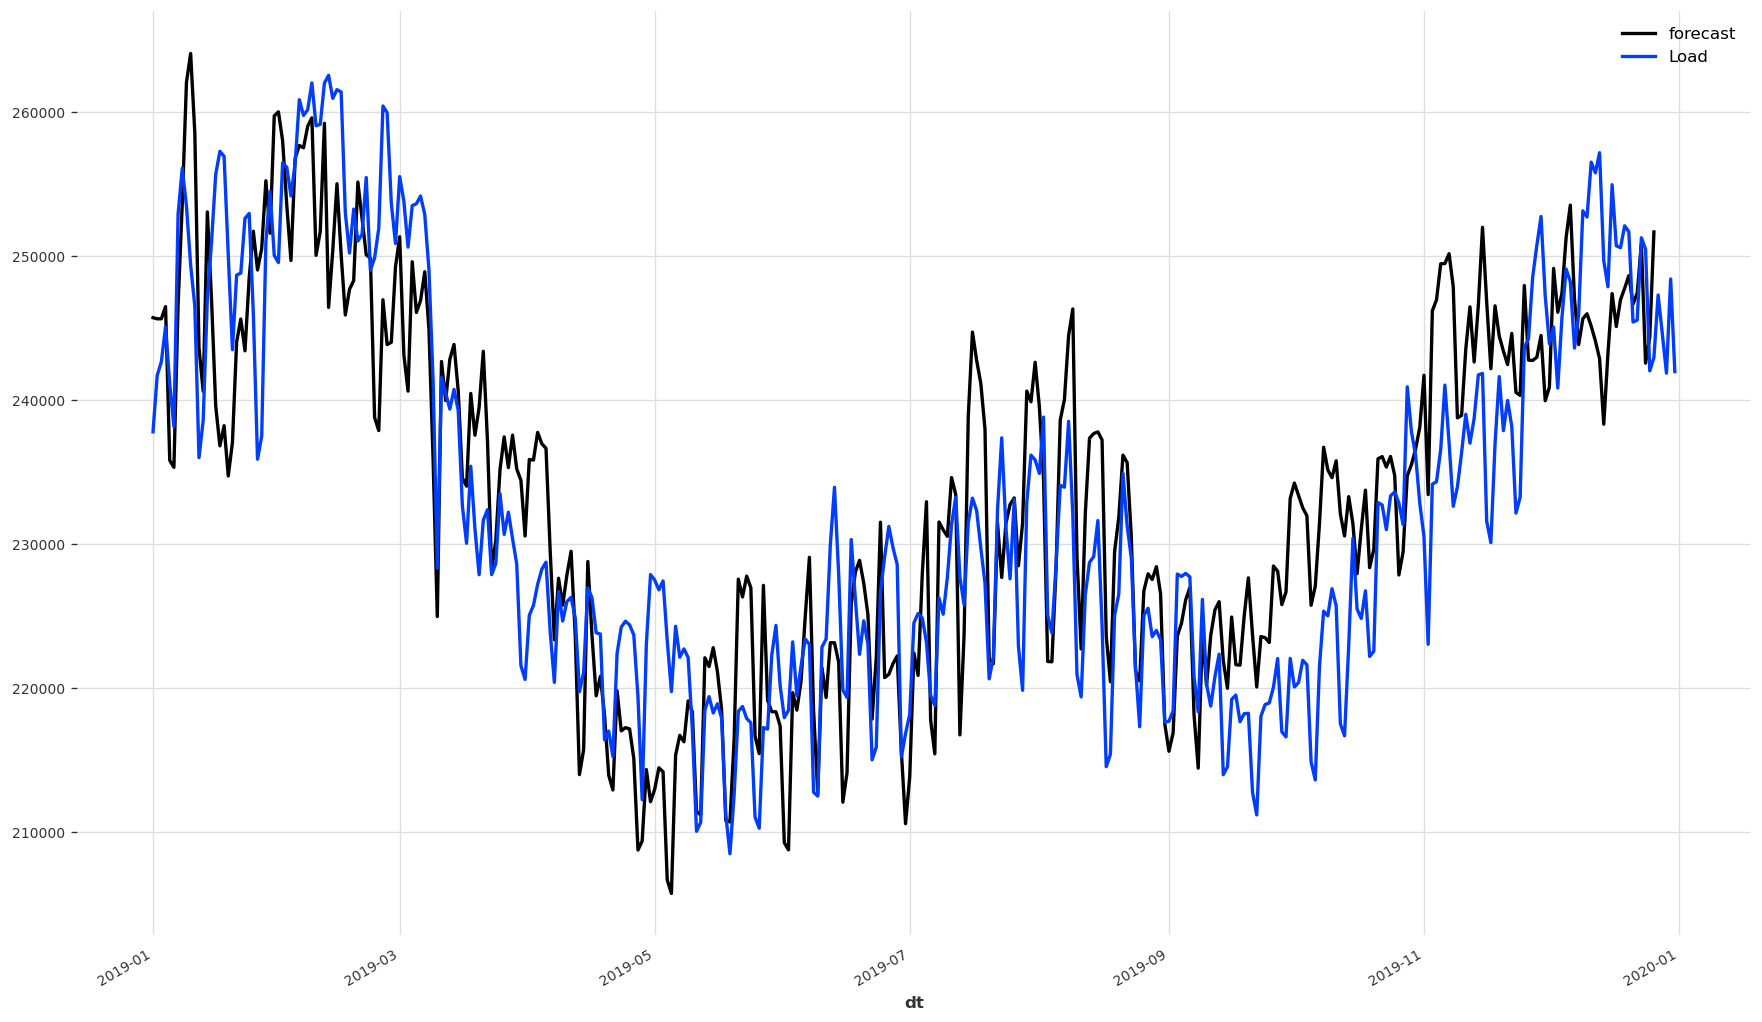

In [25]:
eval_results(seasonal_model)

In [11]:
tbats = TBATS(seasonal_periods=[364,7])
tbats.fit(train)

Total error (RMSE) over all historical forecasts: 5730.16
Average error (RMSE) over all historical forecasts: 5488.37


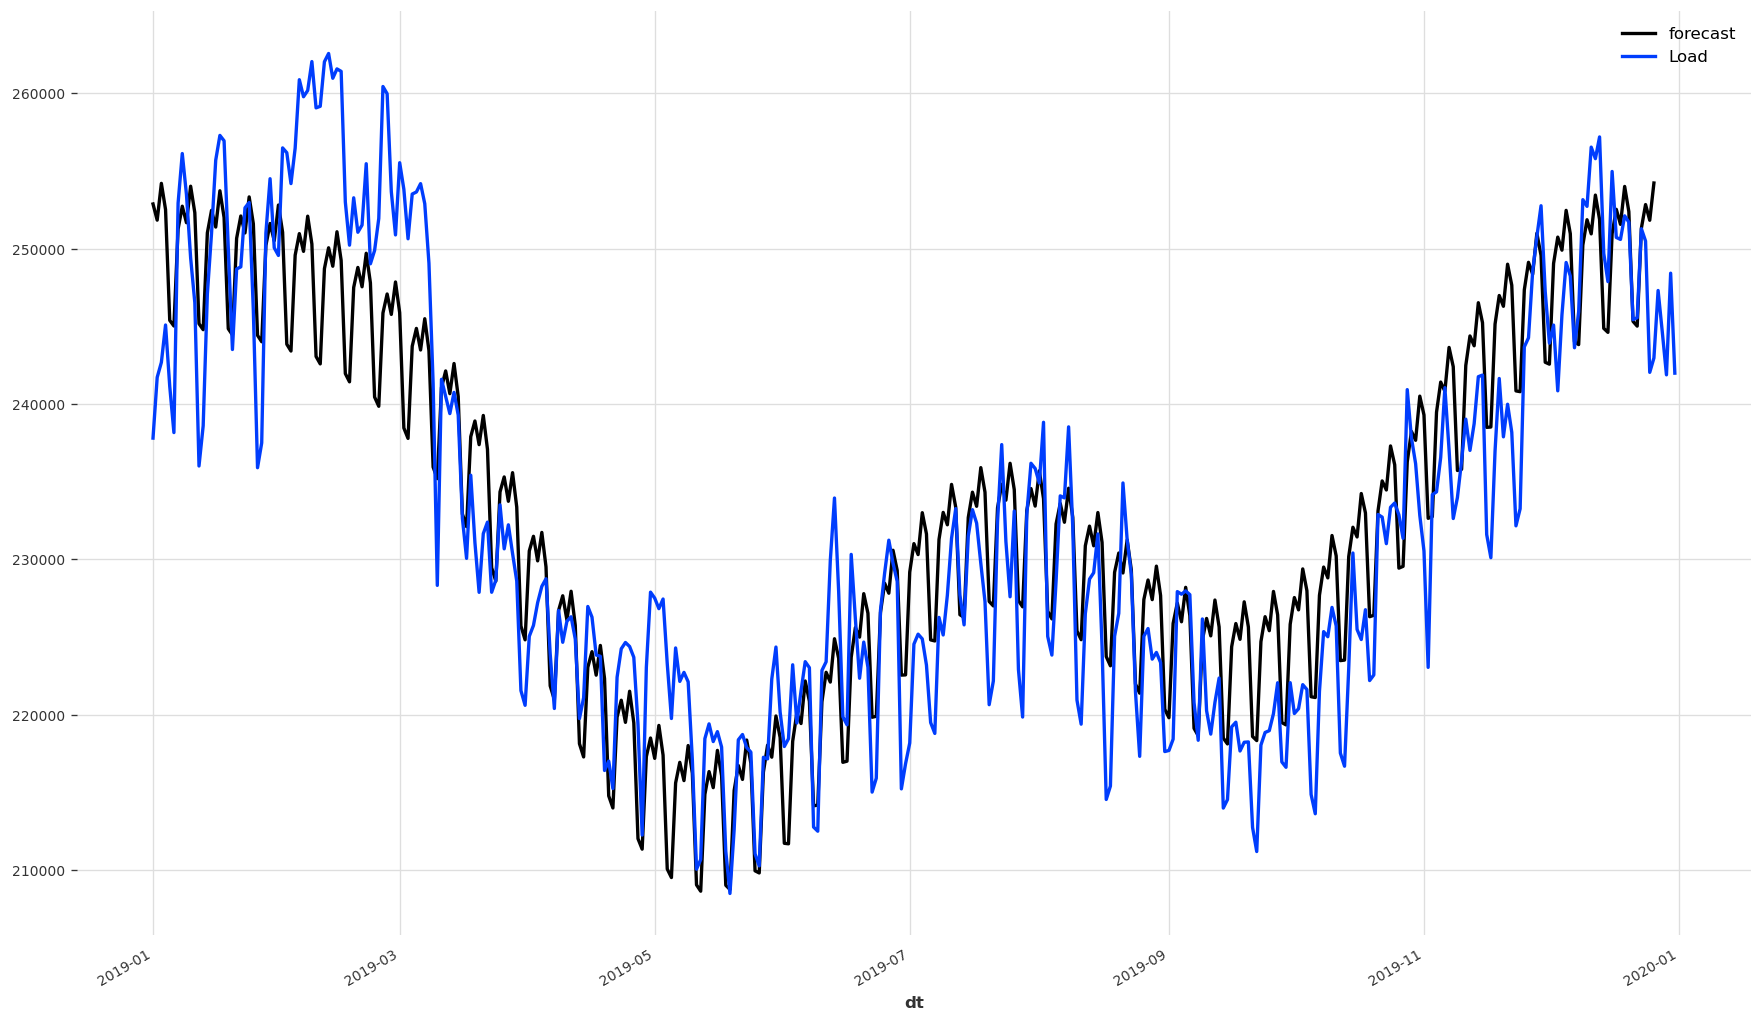

In [27]:
eval_results(tbats)